In [1]:
import pandas as pd
import numpy as np
import torch as th
import paradime
import paradime.dr
import paradime.loss
import paradime.routines
import paradime.utils
from matplotlib import pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import torchvision
from itertools import combinations
import mplcursors

/Users/isabellapetrache/miniconda3/envs/Bachelor/lib/python3.10/site-packages/paradime/transforms.py:285: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _entropy(dists: np.ndarray, beta: float) -> float:


In [2]:
covertype = sklearn.datasets.fetch_covtype()

_, counts = np.unique(covertype.target, return_counts=True)
weights = np.array([ 1/counts[i-1] for i in covertype.target ])

indices = list(th.utils.data.WeightedRandomSampler(weights, 7000))

raw_data = covertype.data[indices,:10]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(raw_data)
data = scaler.transform(raw_data)

label_to_name = {
    1: "Spruce/fir",
    2: "Lodgepole pine",
    3: "Ponderosa pine",
    4: "Cottonwood/willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz",
}

labels = covertype.target[indices]

same_label = (np.outer(labels, np.ones_like(labels))
    - np.outer(np.ones_like(labels), labels) == 0).astype(float)

In [3]:
class twoNAM(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, output_dim=2, num_layers=1):
        super(twoNAM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        # Create submodules for each combination of input feature and output dimension
        self.submodules = th.nn.ModuleDict()
        for i in range(input_dim):
            for j in range(output_dim):
                key = f"{i}_{j}"
                self.submodules[key] = self.create_submodule(num_layers, hidden_dim)

    def create_submodule(self, num_layers, hidden_dim):
        submodule = th.nn.Sequential()
        for l in range(num_layers):
            if l == 0:
                submodule.add_module(f"linear_{l}", th.nn.Linear(1, hidden_dim))
            else:
                submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
            submodule.add_module(f"ELU_{l}", th.nn.ELU())
        submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, 1))
        return submodule

    def forward(self, x):
        outputs = th.zeros(x.shape[0], self.output_dim)
        for j in range(self.output_dim):
            for i in range(self.input_dim):
                key = f"{i}_{j}"
                outputs[:, j] += self.submodules[key](x[:, i].unsqueeze(1)).squeeze()
        return outputs
    
    def embed(self, x):
        return self.forward(x)

    
    def secondget_feature_maps(self, resolution=100):
        output_1D = th.zeros(self.input_dim, resolution, self.output_dim)
        for i in range(self.input_dim):
            for j in range(resolution):
                # Changed sampling from -1-1 to -3-3
                input_value = th.tensor([[-3 + 6 * j / (resolution - 1)]]).float()
                for d in range(self.output_dim):
                    key = f"{i}_{d}"
                    output_1D[i, j, d] = self.submodules[key](input_value)
        return output_1D.detach().numpy()

In [4]:
tsne_global_rel = paradime.relations.NeighborBasedPDist(
    transform=[
        paradime.transforms.PerplexityBasedRescale(
            perplexity=200, bracket=[0.001, 1000]
        ),
        paradime.transforms.Symmetrize(),
        paradime.transforms.Normalize(),
    ]
)


tsne_batch_rel = paradime.relations.DifferentiablePDist(
    transform=[
        paradime.transforms.StudentTTransform(alpha=1.0),
        paradime.transforms.Normalize(),
        paradime.transforms.ToSquareTensor(),
    ]
)


embeddings = []
  
new_losses = {
   
    "embedding": paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div,
        global_relation_key="tsne",
    )
}

In [5]:
super_tsne = paradime.dr.ParametricDR(
    model=twoNAM(
        input_dim=10, hidden_dim=100, num_classes=7, output_dim=2,
    ),
    global_relations={
        "tsne": tsne_global_rel,
        "same_label": paradime.relations.Precomputed(same_label),
    },
    batch_relations=tsne_batch_rel,
    losses=new_losses,
    use_cuda=False,
    verbose=True,
)

###########

#super_tsne.add_training_phase(tsne_init)
super_tsne.add_training_phase(
    name="embedding",
    loss_keys=["embedding"],
    loss_weights=[1],
    sampling="negative_edge",
    neg_sampling_rate=1,
    edge_rel_key="same_label",
    batch_size=500,
    epochs=40,
    learning_rate=0.02,
    report_interval=2,
)
super_tsne.train(data)

embeddings.append(super_tsne.apply(data))

2023-12-20 16:24:51,767: Initializing training dataset.
2023-12-20 16:24:51,771: Computing global relations 'tsne'.
2023-12-20 16:24:51,771: Indexing nearest neighbors.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2023-12-20 16:25:07,018: Calculating probabilities.
2023-12-20 16:25:07,919: Computing global relations 'same_label'.
2023-12-20 16:25:08,399: Beginning training phase 'embedding'.
2023-12-20 16:25:09,375: Loss after epoch 0: 0.01021934358868748
2023-12-20 16:25:11,120: Loss after epoch 2: 0.009246809873729944
2023-12-20 16:25:12,936: Loss after epoch 4: 0.008937317878007889
2023-12-20 16:25:14,681: Loss after epoch 6: 0.008569565718062222
2023-12-20 16:25:16,398: Loss after epoch 8: 0.008487909799441695
2023-12-20 16:25:18,232: Loss after epoch 10: 0.00845215271692723
2023-12-20 16:25:19,992: Loss after epoch 12: 0.008450189023278654
2023-12-20 16:25:21,738: Loss after epoch 14: 0.008388633141294122
2023-12-20 16:25:23,455: Loss after epoch 16: 0.008341550943441689
2023-12-20 16:25:25,173: Loss after epoch 18: 0.008285436313599348
2023-12-20 16:25:26,860: Loss after epoch 20: 0.008330279379151762
2023-12-20 16:25:28,599: Loss after epoch 22: 0.008323276764713228
2023-12-20 16:25:30,42

In [24]:
def plot_feature_maps(model, feature_names = covertype.feature_names):

    feature_maps = model.secondget_feature_maps()

    input_range = np.linspace(-3, 3, feature_maps.shape[1])

    # Check if feature names are provided
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(feature_maps.shape[0])]

    # Create a single figure for all subplots
    plt.figure(figsize=(22, 22)) 


    for i in range(model.input_dim):
        # Create subplot
        ax = plt.subplot(5, 2, i+1)  # 10 feature maps arranged in a 5x2 grid

        # Plot for each output dimension x & y
        for j in range(model.output_dim):
            ax.plot(input_range, feature_maps[i, :, j], label=f"Output Dimension {j}")

        ax.set_xlim(-3, 3)
        ax.set_ylim(-10, 10)
        ax.set_title(f"Feature Map for {feature_names[i]} / Feature {i+1}")
        ax.set_xlabel("Input Value")
        ax.set_ylabel("Output Value")
        ax.legend()
        ax.grid(True)

        
    plt.tight_layout() 
    plt.show()

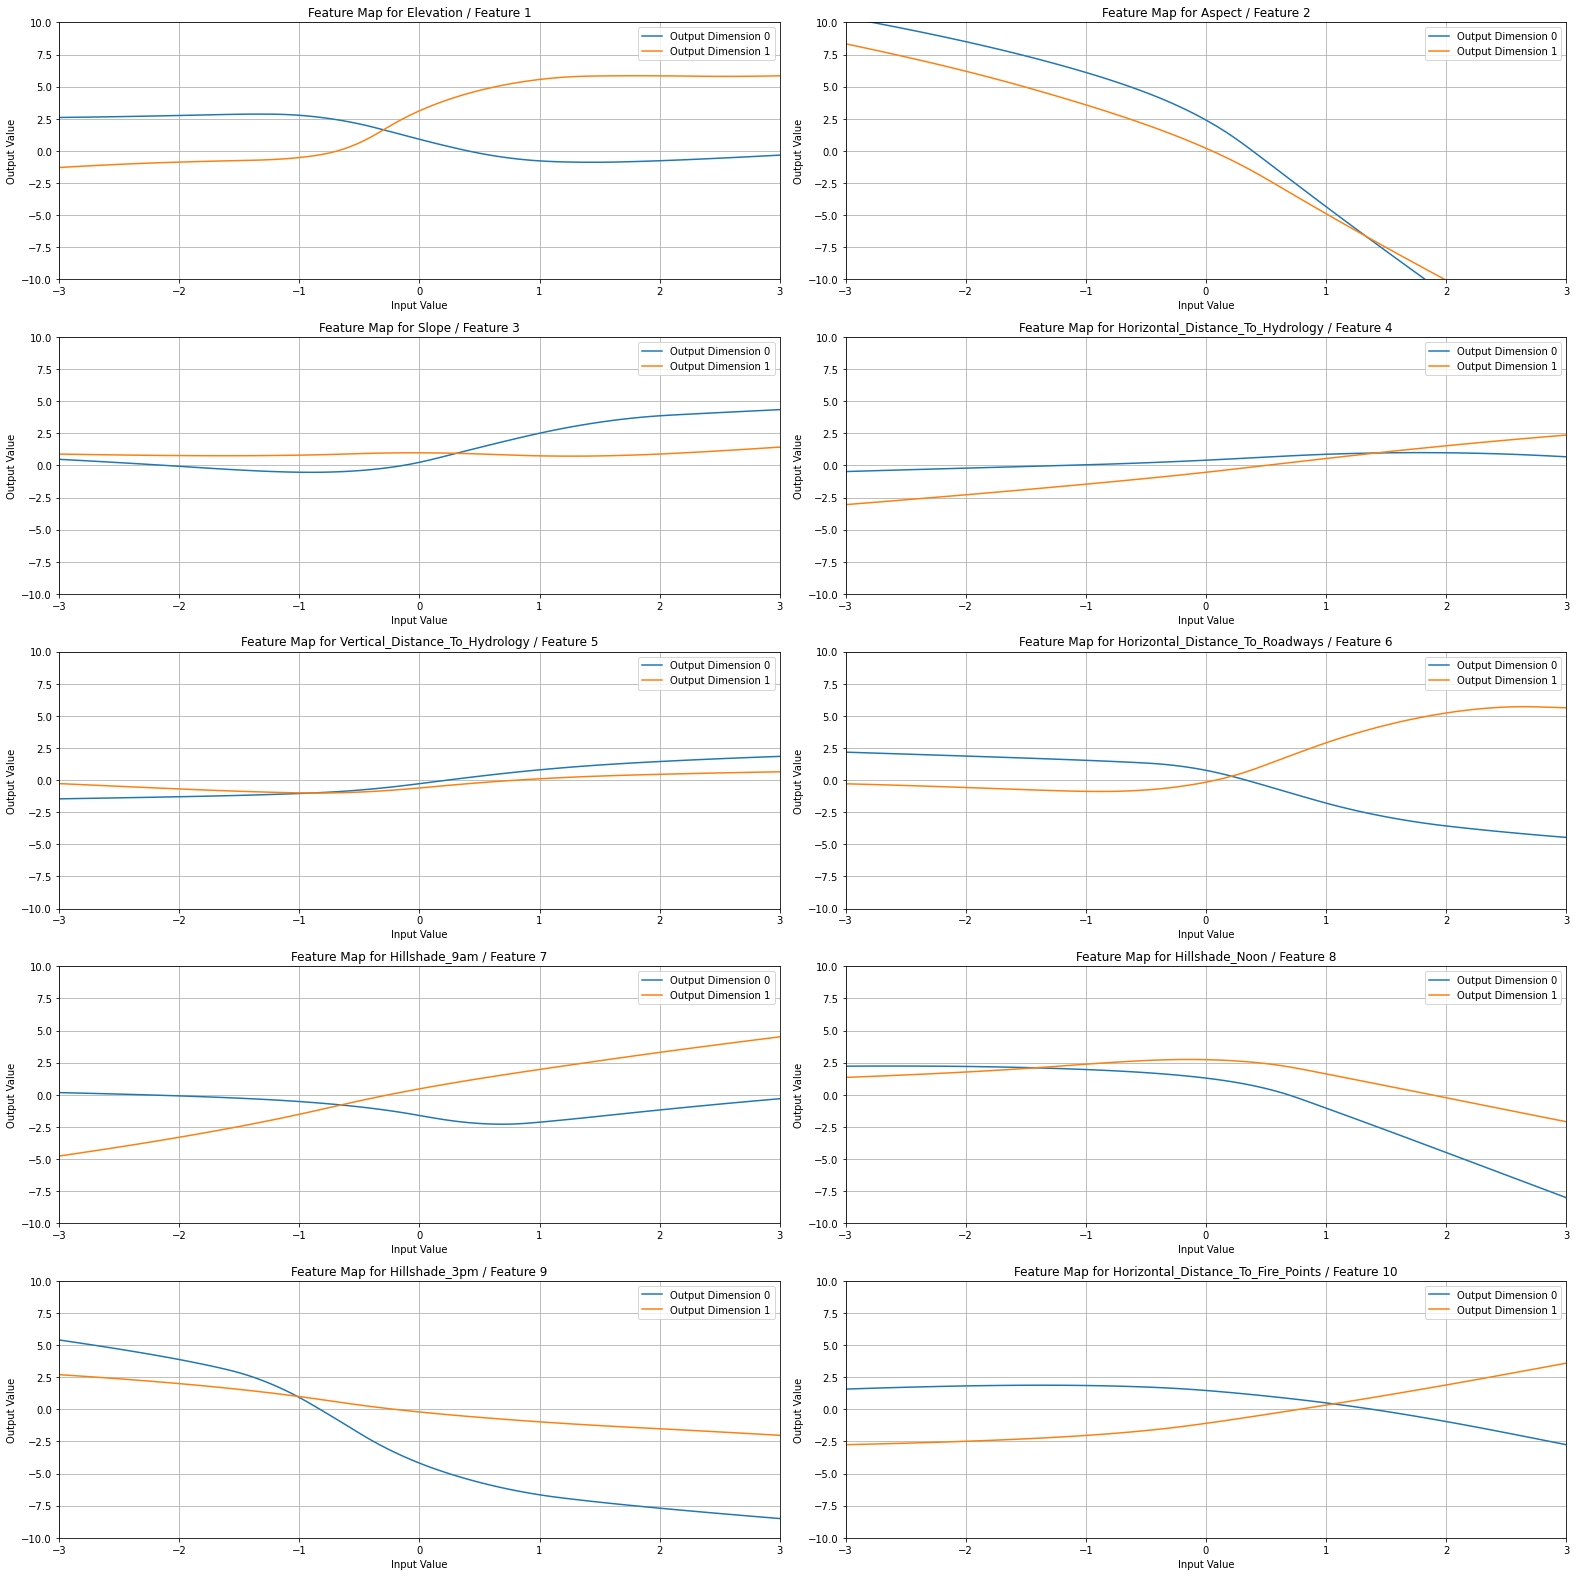

In [25]:
plot_feature_maps(super_tsne.model)

Here, we plot the feature maps too, now all sharing the same format with x ranging from -3 to 3 and y from -10 to 10.


Question asked during last meeting: "If I take a sample and look up its feature values in the feature maps for every feature, I end up with two sums, one sum of all x and one sum of all y values. Is the resulting sum pair (x,y) then the final coordinate in the embedding?"
Inversion was mentioned for that but still unsure; neural networks are generally not easily invertible.

<Axes: >

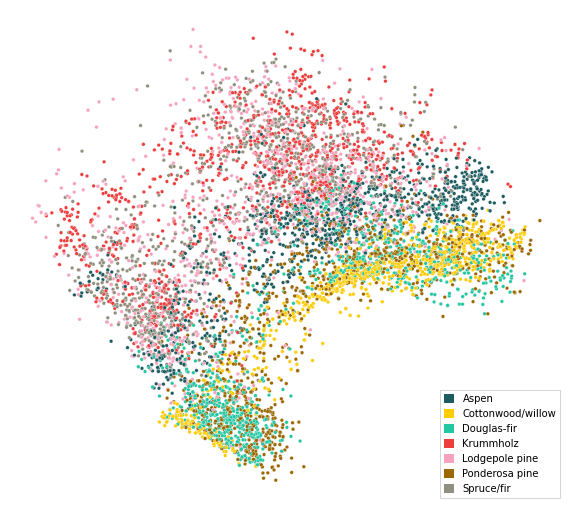

In [8]:
paradime.utils.plotting.scatterplot(
    embeddings[0],
    labels=[label_to_name[i] for i in covertype.target[indices]],
)

<Axes: >

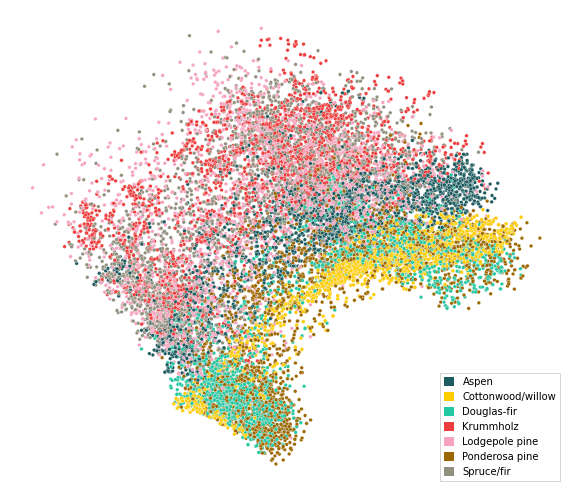

In [9]:
sec_indices = list(th.utils.data.WeightedRandomSampler(weights, 18000))

sec_raw_data = covertype.data[sec_indices,:10]
scaler.fit(sec_raw_data)
para_data = scaler.transform(sec_raw_data)

paradime.utils.plotting.scatterplot(super_tsne.apply(para_data), 
                                   labels=[label_to_name[i] for i in covertype.target[sec_indices]])

I have decided to add the element of interaction with the plots by being able to hover over every sample. It turned out to be cumbersome to make the star plots appear directly next to the scatterplot, as you hover the sample but instead it is possible to pick a sample, read its subsample ID and use that as input for the function, that then plots the graph for that specific sample.

In [10]:
import plotly.express as px


x = embeddings[0][:, 0].cpu().numpy()
y = embeddings[0][:, 1].cpu().numpy()

df = pd.DataFrame({
    'x': x,
    'y': y,
    'label': [label_to_name[i] for i in covertype.target[indices]],
    'sample_id_original': indices,  # Original sample ID from the full dataset
    'sample_id_subsample': list(range(len(indices)))  # Local ID for the subsampled data
})

fig = px.scatter(df, x='x', y='y', 
                 color='label', 
                 hover_data=['x', 'y', 'sample_id_original', 'sample_id_subsample'], 
                 labels={'label': 'Tree Type'},
                 title='Embeddings Visualization')

# gridlines
grid_size = 30
xedges = np.linspace(x.min(), x.max(), grid_size)
yedges = np.linspace(y.min(), y.max(), grid_size)

for xedge in xedges:
    fig.add_shape(type="line", x0=xedge, y0=y.min(), x1=xedge, y1=y.max(), line=dict(color="gray", width=0.5, dash="dot"))
for yedge in yedges:
    fig.add_shape(type="line", x0=x.min(), y0=yedge, x1=x.max(), y1=yedge, line=dict(color="gray", width=0.5, dash="dot"))

fig.show()

In [11]:

def feature_contributions(sample_id, data, model):
    x = data[sample_id].unsqueeze(0).float() # data is in float32 format
    
    feature_maps = model.secondget_feature_maps()

    contributions = []

    for j in range(2):
        for i in range(model.input_dim):
            key = f"{i}_{j}"
            avg_contrib = feature_maps[i, :, j].mean()
            actual_contrib = model.submodules[key](x[0, i].unsqueeze(0).unsqueeze(0))
            contributions.append((actual_contrib - avg_contrib).item())

 
    half = len(contributions) // 2
    x_contributions = contributions[:half]
    y_contributions = contributions[half:]

    return x_contributions, y_contributions

def plot_star_glyph(contributions, title):
    
    num_vars = len(contributions)

    # Calculate angle for each axis in the plot
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]

    # Append the start value to each contribution list for it to be closed
    contributions += contributions[:1]

    # polar subplot
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Set the first axis on top
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(range(1, num_vars + 1))
    
    # Draw the outline of our data
    ax.plot(angles, contributions, linewidth=2, linestyle='solid')
    ax.fill(angles, contributions, alpha=0.4)
    
    plt.title(title)

    plt.show()

def visualize_star_glyph(sample_id, data, model):
    x_contributions, y_contributions = feature_contributions(sample_id, data, model)

    # Normalize contributions for better visualization
    max_val = max(max(x_contributions), max(y_contributions))
    x_contributions = [c / max_val for c in x_contributions]
    y_contributions = [c / max_val for c in y_contributions]


    plot_star_glyph(x_contributions, "X Dimension Contributions")
    plot_star_glyph(y_contributions, "Y Dimension Contributions")


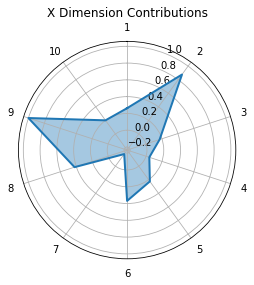

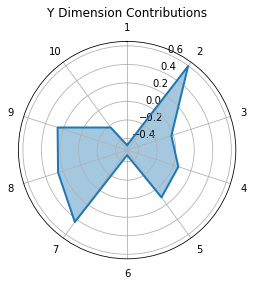

In [12]:
# Sample function call; pick a sample to see how the features affected its x & y coordinates

sample_id = 1573
visualize_star_glyph(sample_id, th.tensor(data), super_tsne.model)

For each feature, we computed the average contribution over all points (this is done by taking the mean of each feature's NAM curve).Then Calculated the actual contribution of the feature to the target for a specific data point.Lastly the difference between the actual and average contributions was calculated.
That method uses the mean of the feature map as a reference.

Positive Contributions: The feature is making a positive impact on the target variable. That means the feature is pushing the model's output value up for the respective x & y coordinate.


Negative Contributions: The feature is making a negative impact on the target variable. That means the feature is pulling the model's output value down for the respective x & y coordinate.


-----------------------

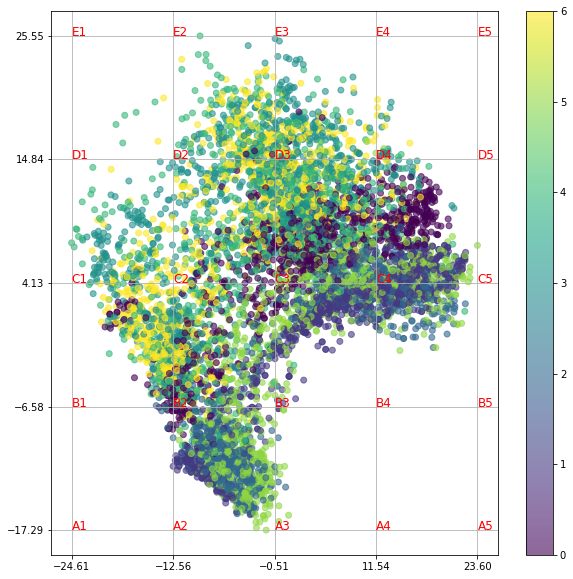

In [13]:
import math

def plot_scatter_with_grid(embeddings, labels, grid_size=5):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(labels)
    numeric_labels = le.transform(labels)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(x, y, c=numeric_labels, cmap='viridis', alpha=0.6)

    # Creating the grid
    plt.grid(True)
    plt.xticks(np.linspace(min(x), max(x), grid_size))
    plt.yticks(np.linspace(min(y), max(y), grid_size))

    # Adding labels to grid cells
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(np.linspace(min(x), max(x), grid_size)[i], np.linspace(min(y), max(y), grid_size)[j], f'{chr(65+j)}{i+1}', color="red", fontsize=12)

    plt.colorbar(scatter)
    plt.show()


plot_scatter_with_grid(np.array(embeddings[0]), [label_to_name[i] for i in labels])



In [14]:

def feature_contributions(sample_id, data, model): # slightly altered
    x = th.tensor(data[sample_id], dtype=th.float32).unsqueeze(0)
    
    feature_maps = model.secondget_feature_maps()

    contributions = []

    for j in range(2):
        for i in range(model.input_dim):
            key = f"{i}_{j}"
            avg_contrib = feature_maps[i, :, j].mean()
            actual_contrib = model.submodules[key](x[0, i].unsqueeze(0).unsqueeze(0))
            contributions.append((actual_contrib - avg_contrib).item())

 
    half = len(contributions) // 2
    x_contributions = contributions[:half]
    y_contributions = contributions[half:]

    return x_contributions, y_contributions

def bin_datapoints(embeddings, grid_size=5):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    bins = {}

    x_bins = np.linspace(min(x), max(x), grid_size)
    y_bins = np.linspace(min(y), max(y), grid_size)

    for i, (x_val, y_val) in enumerate(zip(x, y)):
        x_bin = np.digitize(x_val, x_bins) - 1
        y_bin = np.digitize(y_val, y_bins) - 1
        bin_label = f'{chr(65+y_bin)}{x_bin+1}'

        if bin_label not in bins:
            bins[bin_label] = []
        bins[bin_label].append(i)

    return bins

bins = bin_datapoints(np.array(embeddings[0]))

def aggregated_feature_contributions(bin_ids, data, model):
    all_x_contributions = []
    all_y_contributions = []

    for sample_id in bin_ids:
        x_contributions, y_contributions = feature_contributions(sample_id, data, model)
        all_x_contributions.append(x_contributions)
        all_y_contributions.append(y_contributions)

    avg_x_contributions = np.mean(all_x_contributions, axis=0)
    avg_y_contributions = np.mean(all_y_contributions, axis=0)

    return avg_x_contributions, avg_y_contributions


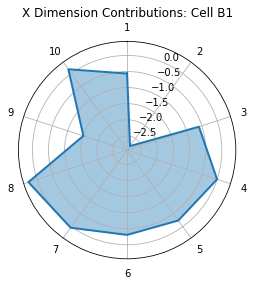

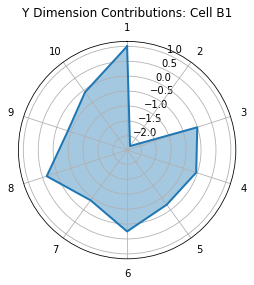

In [19]:
def plot_cell_glyphs(bins, data, model, target_bin_label):
    if target_bin_label not in bins:
        print(f"No data found for bin label {target_bin_label}")
        return

    bin_ids = bins[target_bin_label]
    avg_x_contributions, avg_y_contributions = aggregated_feature_contributions(bin_ids, data, model)
    
    # Normalize contributions for visualization
    max_val = max(max(avg_x_contributions), max(avg_y_contributions))
    norm_x_contributions = [c / max_val for c in avg_x_contributions]
    norm_y_contributions = [c / max_val for c in avg_y_contributions]

    plot_star_glyph(norm_x_contributions, f"X Dimension Contributions: Cell {target_bin_label}")
    plot_star_glyph(norm_y_contributions, f"Y Dimension Contributions: Cell {target_bin_label}")

# Calling the function for a specific cell
plot_cell_glyphs(bins, data, super_tsne.model, "B1")
